In [1]:
import numpy as np
#import mega_extinct
import rebound
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
cm = plt.cm.get_cmap('plasma_r')
v_lim = [5, 8]

In [2]:
#sims = mega_extinct.get_simulations()

In [3]:
MEarth = 5.97e24
REarth = 6378.135e3

constellations = {
    "Starlink": [ {'NPLANES':7178,'SATPP':1,'INC':30,'ALT':328},
        {'NPLANES':7178,'SATPP':1,'INC':40,'ALT':334},
        {'NPLANES':7178,'SATPP':1,'INC':53,'ALT':345},
        {'NPLANES':40,'SATPP':50,'INC':96.9,'ALT':360},
        {'NPLANES':1998,'SATPP':1,'INC':75,'ALT':373},
        {'NPLANES':4000,'SATPP':1,'INC':53,'ALT':499},
        {'NPLANES':12,'SATPP':12,'INC':148,'ALT':604},
        {'NPLANES':18,'SATPP':18,'INC':115.7,'ALT':614},
        {'NPLANES':2547,'SATPP':1,'INC':53,'ALT':345.6},
        {'NPLANES':2478,'SATPP':1,'INC':48,'ALT':340.8},
        {'NPLANES':2493,'SATPP':1,'INC':42,'ALT':335.9},
        {'NPLANES':32,'SATPP':50,'INC':53,'ALT':550},
        {'NPLANES':72,'SATPP':22,'INC':53.2,'ALT':540},
        {'NPLANES':36,'SATPP':20,'INC':70,'ALT':570},
        {'NPLANES':6,'SATPP':58,'INC':97.6,'ALT':560},
        {'NPLANES':4,'SATPP':43,'INC':97.6,'ALT':560.1},],
    "OneWeb": [ {'NPLANES':18,'SATPP':40,'INC':87.9,'ALT':1200},
        {'NPLANES':36,'SATPP':49,'INC':87.9,'ALT':1200},
        {'NPLANES':32,'SATPP':72,'INC':40,'ALT':1200},
        {'NPLANES':32,'SATPP':72,'INC':55,'ALT':1200},],
    "StarNet/GW": [ {'NPLANES':16,'SATPP':30,'INC':85,'ALT':590},
        {'NPLANES':40,'SATPP':50,'INC':50,'ALT':600},
        {'NPLANES':60,'SATPP':60,'INC':55,'ALT':508},
        {'NPLANES':48,'SATPP':36,'INC':30,'ALT':1145},
        {'NPLANES':48,'SATPP':36,'INC':40,'ALT':1145},
        {'NPLANES':48,'SATPP':36,'INC':50,'ALT':1145},
        {'NPLANES':48,'SATPP':36,'INC':60,'ALT':1145},],
    "Kuiper": [ {'NPLANES':34,'SATPP':34,'INC':51.9,'ALT':630},
        {'NPLANES':36,'SATPP':36,'INC':42,'ALT':610},
        {'NPLANES':28,'SATPP':28,'INC':33,'ALT':509},],
    }


def add_to_simulation(sim, ICs, debug=False):
    for IC in ICs:
        nplanes=IC['NPLANES']
        nsat=IC['SATPP']
        a = IC['ALT']*1000.+REarth

        Omegas = np.linspace(0.,2.*np.pi,nplanes)
        for i, Omega in enumerate(Omegas):
            # 5 percent jitter
            Ms = np.linspace(0.,2.*np.pi,nsat)+ 2.*np.pi/nsat*0.25*np.random.normal(size=nsat)
            for j, M in enumerate(Ms):
                sim.add(M=M, a=a, omega=0, e=0, Omega=Omega, inc=IC['INC']*np.pi/180.)
                if debug and sim.N>100:
                    return
def rotY(xyz,alpha):
    c, s = np.cos(alpha), np.sin(alpha)
    M = np.array([[c,0,-s],[0,1,0],[s,0,c]])
    return xyz @ M
def rotZ(xyz,alpha):
    c, s = np.cos(alpha), np.sin(alpha)
    M = np.array([[c,-s,0],[s,c,0],[0,0,1]])
    return xyz @ M
def length_of_night(timeOfYear,latitude, p=0):
    # https://www.ikhebeenvraag.be/mediastorage/FSDocument/171/Forsythe+-+A+model+comparison+for+daylength+as+a+function+of+latitude+and+day+of+year+-+1995.pdf
    # p=18 for astronomical twilight
    theta = 2.*np.arctan(0.9671396*np.tan(-timeOfYear/2.+np.pi/4.))
    phi = np.arcsin(0.39795*np.cos(theta))
    return 24./np.pi * np.arccos((np.sin(p*np.pi/180.)+np.sin(latitude*np.pi/180.)*np.sin(phi))/(np.cos(latitude*np.pi/180.)*np.cos(phi)))
   
AIRMASSCOR = 1
airmassCoeff=0.2 
def getAirmass(z):
    X = 1./(np.cos(z) + 0.50572*(6.07995+90-z*180/np.pi)**(-1.6364))  # Kasten and Young (1989)
    #X = 1./np.cos(z) * (1-0.0012*np.tan(z)**2)  # Young and Irvine (1967)
    return X

def get_stereographic_data(sims, latitude, month, hour):
    albedo=0.3
    area=4
    # latitude in degrees
    # month in months from spring euquinox
    # hours in hours since midnight
    latitude = latitude/180.*np.pi 
    tilt = 23.4*np.sin(month/6.*np.pi)/180.*np.pi
    hour = hour/12.*np.pi
    xy, mag = [], []     
    for name in sims:
        sim = sims[name]
        sun = np.array([-1.4959787e+11,0,0]) # in m
        sun = rotY(sun, tilt)
        sun_n = sun/np.linalg.norm(sun)

        obs = np.array([REarth, 0, 0])
        obs = rotY(obs, -latitude)
        obs = rotZ(obs, hour)
        obs_n = obs/np.linalg.norm(obs)

        xyz = np.zeros((sim.N,3),dtype="float64")
        sim.serialize_particle_data(xyz=xyz)
        xyz = xyz[1:] # remove earth


        lit = np.linalg.norm(np.cross(xyz,sun_n),axis=1)>REarth

        xyz = xyz[lit]

        xyz_n = xyz/np.linalg.norm(xyz,axis=1)[:,np.newaxis]
        xyz_r = xyz - obs
        xyz_rd = np.linalg.norm(xyz_r,axis=1)
        xyz_rn = xyz_r/xyz_rd[:,np.newaxis]

        phase = np.arccos(np.clip(np.dot(xyz_rn, -sun_n), -1.0, 1.0)) # assume sun is in -x direction
        #angle = np.abs(np.arccos(dotprod/(obslen*satlen)))
        elevation = (np.pi/2.-np.arccos(np.dot(xyz_rn,obs_n)))/np.pi*180.

        fac1 = 2/(3*np.pi**2)
        magV = -26.74 -2.5*np.log10(fac1 * area * albedo * ( (np.pi-phase)*np.cos(phase) + np.sin(phase) ) ) + 5 * np.log10(xyz_rd)


        xyz = rotZ(xyz, -hour)
        xyz = rotY(xyz, latitude)
        xyz_r = xyz - np.array([REarth, 0, 0])
        xyz_rd = np.linalg.norm(xyz_r,axis=1)
        xyz_rn = xyz_r/xyz_rd[:,np.newaxis]
        
        airmass=getAirmass((elevation)*np.pi/180.)
        #print(elevation,airmass)
        magV+=airmassCoeff*airmass*AIRMASSCOR
        magV+=np.random.normal(0.,0.2,size=len(magV))

        elevation_cut = 0
        xyz_rn = xyz_rn[elevation>elevation_cut]
        magV = magV[elevation>elevation_cut]

        xy.append(xyz_rn[:,1:3]/(1.+xyz_rn[:,0,np.newaxis]))
        mag.append(magV)
    if len(xy)>0:
        return np.concatenate(xy), np.concatenate(mag) 
    else:
        return None, None


def get_simulations(add_constellations=None, use_cache=True):
    if add_constellations is None:
        add_constellations = constellations.keys() # all constellations
    sims = {}
    for c in add_constellations:
        if c not in constellations:
            raise RuntimeError("Constellation %s not found."%c)
        sim = None
        if use_cache:
            filename = "mega_"+"".join(x for x in c if x.isalnum())+".bin"
            try:
                sim = rebound.Simulation(filename)
            except:
                # need to create simulation
                pass
        if sim is None:
            sim = rebound.Simulation()
            sim.G = 6.67430e-11
            sim.add(m=MEarth)
            sim.N_active = 1
            add_to_simulation(sim, constellations[c])
            if use_cache:
                sim.save(filename)
        sims[c] = sim
    return sims

In [4]:
sims = get_simulations()

def generate_fig(filename=None, latitude=50.): 
    months=[-3,0,3]
    hours=[-3,0,3]
    # latitude in degrees
    # months since spring equinox
    # hours since midnight
    fig, axs = plt.subplots(len(hours),len(months),figsize=(11,10), constrained_layout=True, squeeze=False)
    for i, hour in enumerate(hours):
        for j, month in enumerate(months):
            #print(hour,month)
            xy, mag = get_stereographic_data(sims, latitude=latitude, month=month, hour=hour)

            ax = axs[i][j] 
            ax.set_aspect("equal")
            r_lim = 1.02
            ax.set_xlim(-r_lim,r_lim)
            ax.set_ylim(-r_lim,r_lim)

            # hide axes
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            for s in ax.spines:
                ax.spines[s].set_visible(False)

            # setup labels    
            r_labels = 1.11    
            for k, d in enumerate(["N","W","S","E"]):
                ax.text(r_labels*np.sin(k*np.pi/2.),r_labels*np.cos(k*np.pi/2.)-0.02, d, ha="center", va="center",fontsize=14)
            ax.text(0.25,-1.2,"N$_{tot}$=%d"%len(xy),fontsize=18) 
            ax.text(0.25,-1.45,"N$_{vis}$=%d"%len(xy[mag<6.5]),fontsize=18) 

            # background
            ax.add_collection(PatchCollection([plt.Circle((0, 0), 1)], zorder=-10, color="black"))
            ax.add_collection(PatchCollection([plt.Circle((0, 0), 1)], zorder=3, edgecolor="k", facecolor="none", lw=3))

            # plot
            im=ax.scatter(xy[:,0],xy[:,1],s=4, c=mag, cmap=cm,vmin=v_lim[0],vmax=v_lim[1])
            if j==0: #time labels
                if i==0:
                    ax.text(-1.6,0,"\n9pm",verticalalignment='center',rotation='vertical',fontsize=18) 
                if i==1:
                    ax.text(-1.4,0,"midnight",verticalalignment='center',rotation='vertical',fontsize=18)
                if i==2:
                    ax.text(-1.4,0,"3am",verticalalignment='center',rotation='vertical',fontsize=18)
            if i==0: #season labels
                if j==0:
                    ax.text(0,1.2,"Winter Solstice",horizontalalignment='center',fontsize=18)   
                if j==1:
                    ax.text(0,1.2,"Equinox",horizontalalignment='center',fontsize=18)
                if j==2:
                    ax.text(0,1.2,"Summer Solstice",horizontalalignment='center',fontsize=18)
    cb = fig.colorbar(im,ax=axs,shrink=1./2.)
    cb.set_label(label="Vmag",size=18)
    cb.ax.tick_params(labelsize=18)
    cb.ax.text(0,8.5,str(int(latitude))+'$^{\circ}$N',fontsize=22,horizontalalignment='left')
    if filename is not None:
        plt.savefig(filename,facecolor='white', transparent=False,dpi=200)
        plt.close(fig)

In [5]:
generate_fig("PH_hawaii.pdf", latitude=20)
generate_fig("PH_eq.pdf", latitude=0)
generate_fig("PH_north.pdf", latitude=90)
generate_fig("PH_canada.pdf", latitude=50)

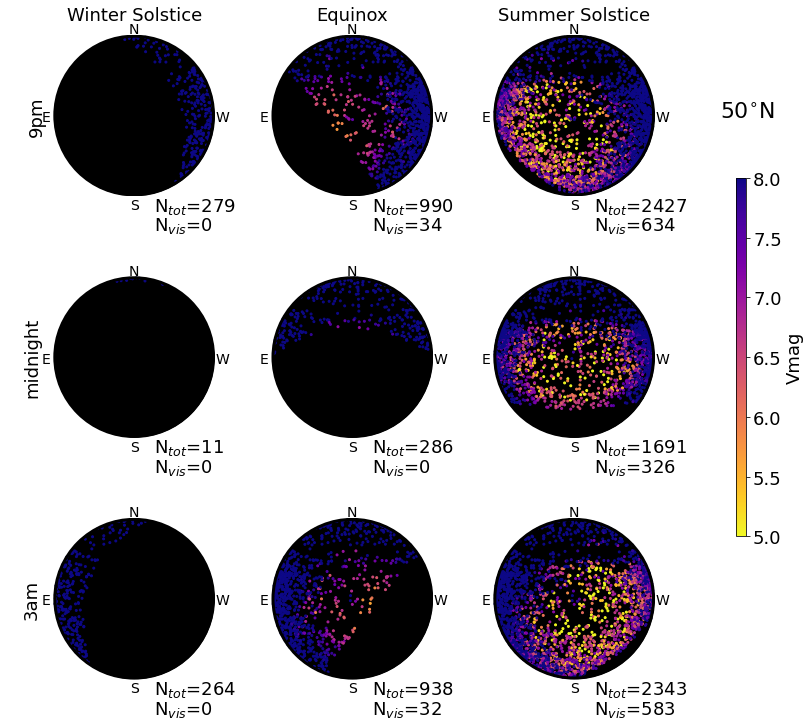

In [6]:
generate_fig(latitude=50.)